### Contents

Background<br/>
Import Modules<br/>
Import Data from BigQuery<br/>
Data Wrangling and Cleaning<br/>
Forecast with Facebook Prophet<br/>
Next Steps


### Background

This document demonstrates extracting a pre-built dataset from BigQuery and then forecasting revenue into the future using Facebook's Prophet.

### Import Modules

Let's import the modules we'll need to generate a LTV for each individual user.

In [17]:
# import python modules
import pandas as pd
import pandas_gbq as gbq
import numpy as np
import datetime as dt
from IPython.display import Image
from fbprophet import Prophet
import matplotlib.pyplot as plt
% matplotlib inline


### Import Data from BigQuery

In [2]:
# Insert your BigQuery Project ID Here
projectid = "gc-bq-199201"

# Use pandas-gbq to read the data from our pre-made transaction table and store it in a df called trans_df.
trans_df = gbq.read_gbq('SELECT * FROM `ga_google_merch_store.transaction_history`', projectid,private_key='GC BQ-51bee32b8194.json',dialect='standard')

# Display the head of the df to confirm we have the data
trans_df.head()

INFO:pandas_gbq.gbq:Total time taken 84.57 s.
Finished at 2018-12-07 14:54:46.


,date,fullVisitorid,transactions,Revenue
0,20160801,7194065619159478122,NaN,NaN
1,20160801,8159312408158297118,NaN,NaN
2,20160801,9236304747882138291,NaN,NaN
3,20160801,1792676004815023069,NaN,NaN
4,20160801,7305625498291809599,NaN,NaN


### Let's Clean Some of this Data

Now let's explore and clean this data. Things that need to get done:

1. Change the data type for date to a datetime
2. Replace any NaNs or None's with 0

#### Convert the date format

In [3]:
# Convert the date format to yyyy-mm-dd
trans_df['date'] = trans_df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [4]:
# Successfully converted date format.
trans_df.head()

,date,fullVisitorid,transactions,Revenue
0,2016-08-01,7194065619159478122,NaN,NaN
1,2016-08-01,8159312408158297118,NaN,NaN
2,2016-08-01,9236304747882138291,NaN,NaN
3,2016-08-01,1792676004815023069,NaN,NaN
4,2016-08-01,7305625498291809599,NaN,NaN


#### Replacing the NaN/None Values with 0

In [5]:
# Replace Revenue and Tranactions that are NaN/None with 0
trans_df['Revenue'].fillna(0, inplace=True)
trans_df['transactions'].replace(to_replace="None", value=0, inplace=True)
trans_df['transactions'].fillna(0, inplace=True)

# Confirm NaN/None values have been replaced with 0
trans_df.head()


,date,fullVisitorid,transactions,Revenue
0,2016-08-01,7194065619159478122,0.0,0.0
1,2016-08-01,8159312408158297118,0.0,0.0
2,2016-08-01,9236304747882138291,0.0,0.0
3,2016-08-01,1792676004815023069,0.0,0.0
4,2016-08-01,7305625498291809599,0.0,0.0


Ok. Everything looks good!

In [6]:
### Let's Group the data by date
data = trans_df.groupby('date').sum()


In [7]:
data.head()

,transactions,Revenue
date,,
2016-08-01,34.0,6116.06
2016-08-02,18.0,1361.19
2016-08-03,0.0,0.00
2016-08-04,17.0,1182.89
2016-08-05,42.0,5594.26


In [11]:
data = data.reset_index()

In [12]:
data.head()

,date,transactions,Revenue
0,2016-08-01,34.0,6116.06
1,2016-08-02,18.0,1361.19
2,2016-08-03,0.0,0.00
3,2016-08-04,17.0,1182.89
4,2016-08-05,42.0,5594.26


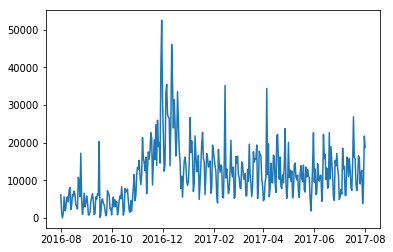

In [16]:
# Let's do a quick plot of Revenue
plt.plot(data['date'],data['Revenue'])
plt.show()

In [ ]:
Ok. I think we are ready to do a quick forecast.

### Forecasting with FB Prophet

To do this, we'll need to:

1. Drop a column
2. Convert the names of the columns so that Prophet can fit the model.



#### Drop Column

In [18]:
data = data.drop(columns='transactions')

#### Rename Column Names

In [20]:
data.rename(index=str, columns={"date": "ds", "Revenue": "y"}, inplace=True)

In [21]:
data.head()

,ds,y
0,2016-08-01,6116.06
1,2016-08-02,1361.19
2,2016-08-03,0.00
3,2016-08-04,1182.89
4,2016-08-05,5594.26


### Now let's fit the model

In [23]:
# Fit prophet
m = Prophet(daily_seasonality=True)
m.fit(data)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


#### Creating a forecast out 30 days

In [25]:
#### Let's forecast out 30 days
future = m.make_future_dataframe(periods=30)

#### Let's Predict the Future ;)

In [26]:
forecast = m.predict(future)
# Here's the data - yhat is what we are looking for
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-08-01,5097.698216,-3590.274698,11207.023829,5097.698216,5097.698216,-961.592412,-961.592412,-961.592412,-4033.103592,-4033.103592,-4033.103592,3071.511180,3071.511180,3071.511180,0.0,0.0,0.0,4136.105805
1,2016-08-02,5215.671015,-2992.000812,11283.354171,5215.671015,5215.671015,-1154.074878,-1154.074878,-1154.074878,-4033.103592,-4033.103592,-4033.103592,2879.028714,2879.028714,2879.028714,0.0,0.0,0.0,4061.596137
2,2016-08-03,5333.643814,-3357.503697,10786.068634,5333.643814,5333.643814,-1604.877491,-1604.877491,-1604.877491,-4033.103592,-4033.103592,-4033.103592,2428.226101,2428.226101,2428.226101,0.0,0.0,0.0,3728.766323
3,2016-08-04,5451.616613,-4088.907268,9930.869050,5451.616613,5451.616613,-2945.600798,-2945.600798,-2945.600798,-4033.103592,-4033.103592,-4033.103592,1087.502794,1087.502794,1087.502794,0.0,0.0,0.0,2506.015815
4,2016-08-05,5569.589412,-5270.964328,9355.139613,5569.589412,5569.589412,-3417.188817,-3417.188817,-3417.188817,-4033.103592,-4033.103592,-4033.103592,615.914775,615.914775,615.914775,0.0,0.0,0.0,2152.400595


#### Let's visualize it now with some cool looking graphs

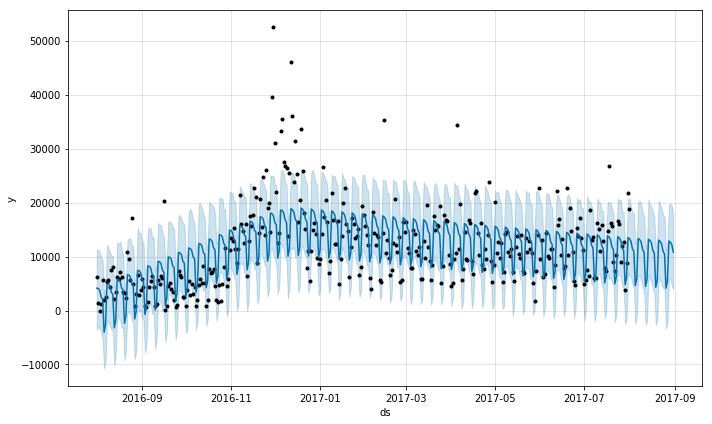

In [27]:
fig1 = m.plot(forecast)

Black dots above are actuals, where blue is the forecast and light blue are the bands

### Next Steps

Some things to consider:

1. Creating a hold-out period and comparing forecast with actuals
2. There clearly is some big changes with the data prior to Jan 2017. Removing this could be interesting